In [1]:
import pandas as pd
import numpy as np

movie_data = pd.read_csv('movie_data.csv')

print(movie_data.head())

movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

print('Movie:', movie_titles[0])
print('Movie Synopsis:', movie_synopses[0][:1000])

                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...
Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks 

In [2]:
from normalization import normalize_corpus
from utils import build_feature_matrix

# normalize corpus
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# view number of features
print(feature_matrix.shape)

# get feature names
feature_names = vectorizer.get_feature_names()

# print sample features
print(feature_names[:20])

(100, 307)
['able', 'accept', 'across', 'act', 'agree', 'alive', 'allow', 'alone', 'along', 'already', 'although', 'always', 'another', 'anything', 'apartment', 'appear', 'approach', 'arm', 'army', 'around']


In [3]:
from sklearn.cluster import KMeans


def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters


num_clusters = 5
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters


In [4]:
from collections import Counter
# get the total number of movies per cluster

c = Counter(clusters)
print(c.items())


def get_cluster_data(clustering_obj, movie_data,
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index]
                        for index
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features

        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies

    return cluster_details

dict_items([(0, 34), (1, 4), (2, 33), (3, 17), (4, 12)])


In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def print_cluster_data(cluster_data):
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('Key features:', cluster_details['key_features'])
        print('Movies in this cluster:')
        print(', '.join(cluster_details['movies']))


def plot_clusters(
    num_clusters,
    feature_matrix,
    cluster_data,
    movie_data,
    plot_size=(16, 8)
):
    # generate random color for clusters
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed",
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({
        'x': x_pos,
        'y': y_pos,
        'label': movie_data['Cluster'].values.tolist(),
        'title': movie_data['Title'].values.tolist()
    })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size)
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
        marker = markers[cluster_num] if cluster_num < len(markers) else np.random.choice(markers, size=1)[0]
        ax.plot(
            cluster_frame['x'],
            cluster_frame['y'],
            marker=marker, linestyle='', ms=12,
            label=cluster_name_map[cluster_num],
            color=cluster_color_map[cluster_num],
            mec='none'
        )
        ax.set_aspect('auto')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True,
              shadow=True, ncol=5, numpoints=1, prop=fontP)

    # add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.iloc[index]['x'],
                cluster_plot_frame.iloc[index]['y'],
                cluster_plot_frame.iloc[index]['title'], size=8)
    # show the plot
    plt.show()


cluster_data = get_cluster_data(
    clustering_obj=km_obj,
    movie_data=movie_data,
    feature_names=feature_names,
    num_clusters=num_clusters,
    topn_features=5
)

print_cluster_data(cluster_data)

Cluster 0 details:
Key features: ['family', 'war', 'army', 'kill', 'return']
Movies in this cluster:
The Godfather, Schindler's List, Casablanca, Gone with the Wind, The Godfather: Part II, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Raiders of the Lost Ark, A Streetcar Named Desire, The Philadelphia Story, An American in Paris, The Best Years of Our Lives, Ben-Hur, Doctor Zhivago, Patton, Dances with Wolves, The Pianist, Goodfellas, The Deer Hunter, All Quiet on the Western Front, The King's Speech, A Place in the Sun, Out of Africa, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, Network, Stagecoach, Yankee Doodle Dandy
Cluster 1 details:
Key features: ['water', 'attempt', 'cross', 'death', 'hang']
Movies in this cluster:
Chinatown, Jaws, The African Queen, Mutiny on the Bounty
Cluster 2 details:
Key featur

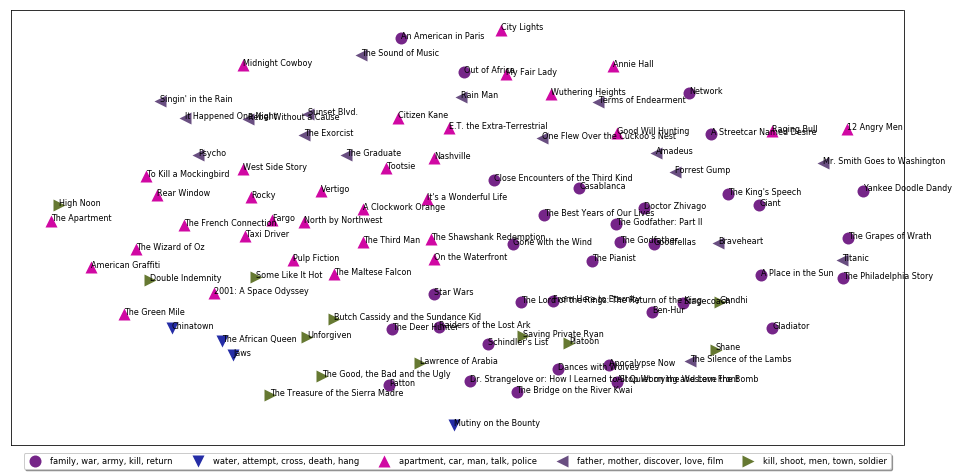

In [6]:
plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
              cluster_data=cluster_data,
              movie_data=movie_data,
              plot_size=(16, 8))

In [7]:
from sklearn.cluster import AffinityPropagation


def affinity_propagation(feature_matrix):
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_
    return ap, clusters


# get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

# get the total number of movies per cluster
c = Counter(clusters)
print(c.items())

# get total clusters
total_clusters = len(c)
print('Total Clusters:', total_clusters)


cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)

print_cluster_data(cluster_data)

dict_items([(0, 5), (1, 6), (2, 12), (3, 6), (4, 2), (5, 7), (6, 10), (7, 7), (8, 4), (9, 8), (10, 3), (11, 4), (12, 5), (13, 7), (14, 4), (15, 3), (16, 7)])
Total Clusters: 17
Cluster 0 details:
Key features: ['able', 'always', 'cover', 'end', 'charge']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
Key features: ['alive', 'accept', 'around', 'agree', 'attack']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
Key features: ['apartment', 'film', 'final', 'fall', 'due']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
Key features: ['arrest', 'film', 'evening', 'final', 'fall']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the 

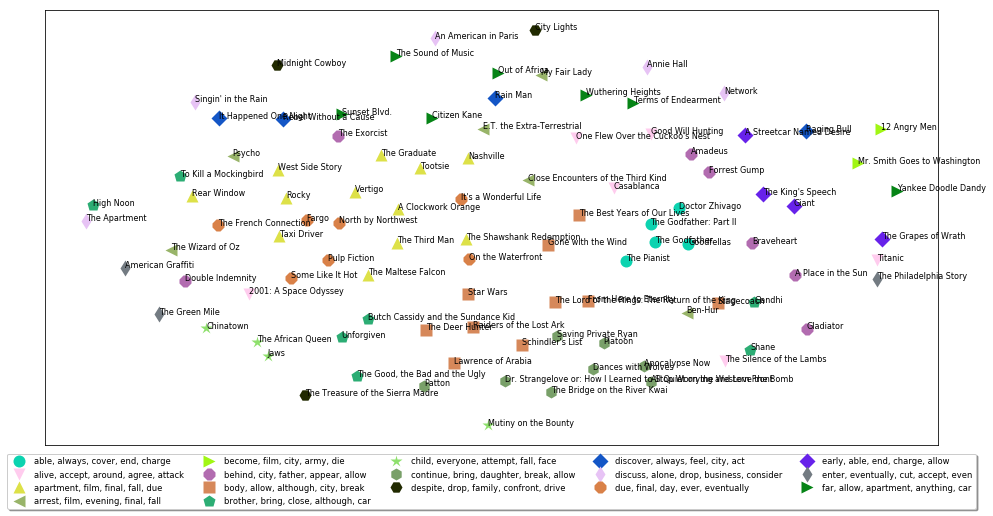

In [8]:
plot_clusters(num_clusters=num_clusters,
              feature_matrix=feature_matrix,
              cluster_data=cluster_data,
              movie_data=movie_data,
              plot_size=(16, 8))

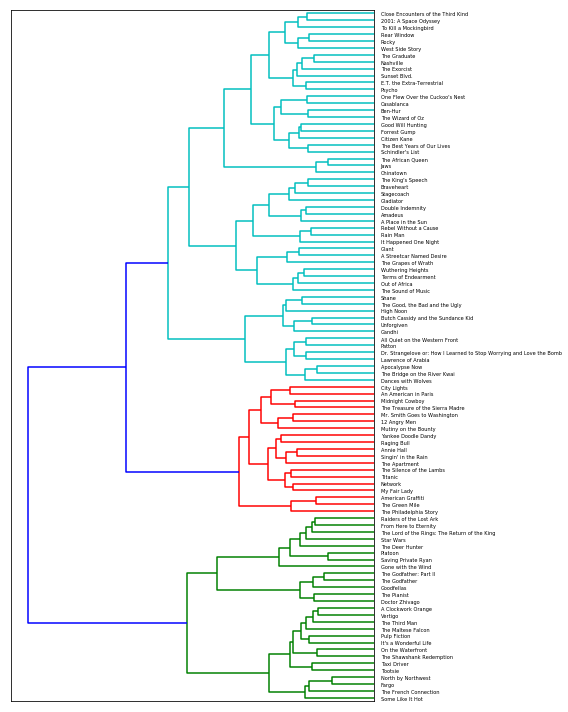

In [9]:
from scipy.cluster.hierarchy import ward, dendrogram


def ward_hierarchical_clustering(feature_matrix):
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix


def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8, 12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size)
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

# build ward's linkage matrix
linkage_matrix = ward_hierarchical_clustering(feature_matrix)

# plot the dendrogram
plot_hierarchical_clusters(
    linkage_matrix=linkage_matrix,
    movie_data=movie_data,
    figure_size=(8, 10)
)
